# SORT 物件追蹤

 此程式我有增加物件軌跡功能與原作者程式有一些表面上的差異

## 下載套件

In [ ]:
!wget https://motchallenge.net/sequenceVideos/MOT16-01-raw.mp4
%pip install ultralytics
%pip install filterpy

## 建立 Sort 物件追蹤器
 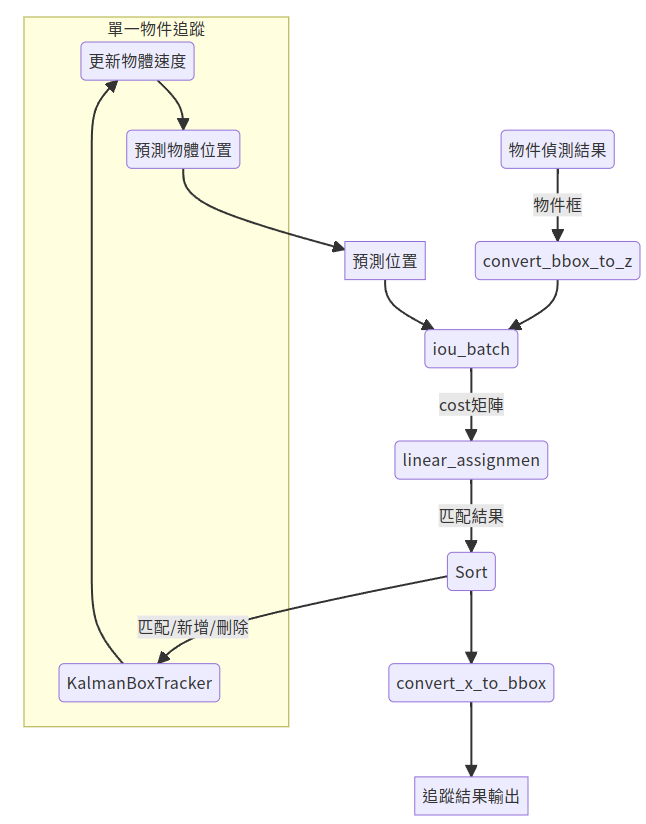



In [ ]:
"""
    SORT: A Simple, Online and Realtime Tracker
    Copyright (C) 2016-2020 Alex Bewley alex@bewley.ai

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""
from __future__ import print_function

import numpy as np
import cv2
from filterpy.kalman import KalmanFilter
from collections import deque
import random

np.random.seed(0)
def linear_assignment(cost_matrix):
  try:
    import lap
    _, x, y = lap.lapjv(cost_matrix, extend_cost=True)
    return np.array([[y[i],i] for i in x if i >= 0]) #
  except ImportError:
    from scipy.optimize import linear_sum_assignment
    x, y = linear_sum_assignment(cost_matrix)
    return np.array(list(zip(x, y)))


def iou_batch(bb_test, bb_gt):
  """
  From SORT: Computes IOU between two bboxes in the form [x1,y1,x2,y2]
  """
  bb_gt = np.expand_dims(bb_gt, 0)
  bb_test = np.expand_dims(bb_test, 1)

  xx1 = np.maximum(bb_test[..., 0], bb_gt[..., 0])
  yy1 = np.maximum(bb_test[..., 1], bb_gt[..., 1])
  xx2 = np.minimum(bb_test[..., 2], bb_gt[..., 2])
  yy2 = np.minimum(bb_test[..., 3], bb_gt[..., 3])
  w = np.maximum(0., xx2 - xx1)
  h = np.maximum(0., yy2 - yy1)
  wh = w * h
  o = wh / ((bb_test[..., 2] - bb_test[..., 0]) * (bb_test[..., 3] - bb_test[..., 1])
    + (bb_gt[..., 2] - bb_gt[..., 0]) * (bb_gt[..., 3] - bb_gt[..., 1]) - wh)
  return(o)


def convert_bbox_to_z(bbox):
  """
  Takes a bounding box in the form [x1,y1,x2,y2] and returns z in the form
    [x,y,s,r] where x,y is the centre of the box and s is the scale/area and r is
    the aspect ratio
  """
  w = bbox[2] - bbox[0]
  h = bbox[3] - bbox[1]
  x = bbox[0] + w/2.
  y = bbox[1] + h/2.
  s = w * h    #scale is just area
  r = w / float(h)
  return np.array([x, y, s, r]).reshape((4, 1))


def convert_x_to_bbox(x,score=None):
  """
  Takes a bounding box in the centre form [x,y,s,r] and returns it in the form
    [x1,y1,x2,y2] where x1,y1 is the top left and x2,y2 is the bottom right
  """
  w = np.sqrt(x[2] * x[3])
  h = x[2] / w
  if(score is None):
    return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.]).reshape((1,4))
  else:
    return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.,score]).reshape((1,5))


class KalmanBoxTracker(object):
  """
  This class represents the internal state of individual tracked objects observed as bbox.
  """
  count = 0
  def __init__(self,bbox):
    """
    Initialises a tracker using initial bounding box.
    """
    #define constant velocity model
    self.kf = KalmanFilter(dim_x=8, dim_z=4)
    self.kf.F = np.array([[1,0,0,0,1,0,0,0],
                          [0,1,0,0,0,1,0,0],
                          [0,0,1,0,0,0,1,0],
                          [0,0,0,1,0,0,0,1],
                          [0,0,0,0,1,0,0,0],
                          [0,0,0,0,0,1,0,0],
                          [0,0,0,0,0,0,1,0],
                          [0,0,0,0,0,0,0,1]])
    self.kf.H = np.array([[1,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,0,0,0,0]])

    self.kf.R[2:,2:] *= 10.
    self.kf.P[4:,4:] *= 1000. #give high uncertainty to the unobservable initial velocities
    self.kf.P *= 10.
    self.kf.Q[-1,-1] *= 0.01
    self.kf.Q[4:,4:] *= 0.01

    self.kf.x[:4] = convert_bbox_to_z(bbox)
    self.time_since_update = 0
    self.id = KalmanBoxTracker.count
    KalmanBoxTracker.count += 1
    self.history = []
    self.hits = 0
    self.hit_streak = 0
    self.age = 0
    self.color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    self.record = deque(maxlen=10)
  def update(self,bbox):
    """
    Updates the state vector with observed bbox.
    """
    self.time_since_update = 0
    self.history = []
    self.hits += 1
    self.hit_streak += 1
    self.kf.update(convert_bbox_to_z(bbox))

  def predict(self):
    """
    Advances the state vector and returns the predicted bounding box estimate.
    """
    if((self.kf.x[6]+self.kf.x[2])<=0):
      self.kf.x[6] *= 0.0
    self.kf.predict()
    self.age += 1
    if(self.time_since_update>0):
      self.hit_streak = 0
    self.time_since_update += 1
    self.history.append(convert_x_to_bbox(self.kf.x))
    return self.history[-1]

  def get_state(self):
    """
    Returns the current bounding box estimate.
    """
    return convert_x_to_bbox(self.kf.x)


def associate_detections_to_trackers(detections,trackers,iou_threshold = 0.3):
  """
  Assigns detections to tracked object (both represented as bounding boxes)

  Returns 3 lists of matches, unmatched_detections and unmatched_trackers
  """
  if(len(trackers)==0):
    return np.empty((0,2),dtype=int), np.arange(len(detections)), np.empty((0,5),dtype=int)
  iou_matrix = iou_batch(detections, trackers)

  if min(iou_matrix.shape) > 0:
    a = (iou_matrix > iou_threshold).astype(np.int32)
    if a.sum(1).max() == 1 and a.sum(0).max() == 1:
        matched_indices = np.stack(np.where(a), axis=1)
    else:
      matched_indices = linear_assignment(-iou_matrix)
  else:
    matched_indices = np.empty(shape=(0,2))

  unmatched_detections = []
  for d, det in enumerate(detections):
    if(d not in matched_indices[:,0]):
      unmatched_detections.append(d)
  unmatched_trackers = []
  for t, trk in enumerate(trackers):
    if(t not in matched_indices[:,1]):
      unmatched_trackers.append(t)

  #filter out matched with low IOU
  matches = []
  for m in matched_indices:
    if(iou_matrix[m[0], m[1]]<iou_threshold):
      unmatched_detections.append(m[0])
      unmatched_trackers.append(m[1])
    else:
      matches.append(m.reshape(1,2))
  if(len(matches)==0):
    matches = np.empty((0,2),dtype=int)
  else:
    matches = np.concatenate(matches,axis=0)

  return matches, np.array(unmatched_detections), np.array(unmatched_trackers)


class Sort(object):
  def __init__(self, max_age=10, min_hits=3, iou_threshold=0.4):
    """
    Sets key parameters for SORT
    """
    self.max_age = max_age
    self.min_hits = min_hits
    self.iou_threshold = iou_threshold
    self.trackers = []
    self.frame_count = 0

  def __call__(self, data=[np.empty((0, 5))]):
    """
    Params:
      dets - a numpy array of detections in the format [[[x1,y1,x2,y2,score]],[[x1,y1,x2,y2,score]]...]
    Requires: this method must be called once for each frame even with empty detections (use np.empty((0, 5)) for frames without detections).
    Returns the a similar array, where the last column is the object ID.

    NOTE: The number of objects returned may differ from the number of detections provided.
    """
    dets = np.array(data)
    if len(dets)<1:
        dets = np.empty((0,5))
    self.frame_count += 1
    # get predicted locations from existing trackers.
    trks = np.zeros((len(self.trackers), 5))
    to_del = []
    ret = []
    for t, trk in enumerate(trks):
      pos = self.trackers[t].predict()[0]
      trk[:] = [pos[0], pos[1], pos[2], pos[3], 0]
      if np.any(np.isnan(pos)):
        to_del.append(t)
    trks = np.ma.compress_rows(np.ma.masked_invalid(trks))
    for t in reversed(to_del):
      self.trackers.pop(t)
    matched, unmatched_dets, unmatched_trks = associate_detections_to_trackers(dets,trks, self.iou_threshold)

    # update matched trackers with assigned detections
    for m in matched:
      self.trackers[m[1]].update(dets[m[0], :])
      self.trackers[m[1]].record.append([int((data[m[0]][0]+data[m[0]][2])*0.5),int((data[m[0]][1]+data[m[0]][3])*0.5)])

    # create and initialise new trackers for unmatched detections
    for i in unmatched_dets:
        trk = KalmanBoxTracker(dets[i,:])
        trk.record.append([int((data[i][0]+data[i][2])*0.5),int((data[i][1]+data[i][3])*0.5)])
        self.trackers.append(trk)

    i = len(self.trackers)
    for trk in reversed(self.trackers):
        d = trk.get_state()[0]
        if (trk.time_since_update < 1) and (trk.hit_streak >= self.min_hits):
          ret.append(np.concatenate((d,[trk.id+1])).reshape(1,-1)) # +1 as MOT benchmark requires positive
        i -= 1
        # remove dead tracklet
        if(trk.time_since_update > self.max_age):
          self.trackers.pop(i)
    if(len(ret)>0):
        return np.concatenate(ret)
    return np.empty((0,5))

  def draw_track_box(self,img):
    i = len(self.trackers)
    for trk in reversed(self.trackers):
        d = trk.get_state()[0]
        if (trk.time_since_update < 1) and (trk.hit_streak >= self.min_hits or self.frame_count <= self.min_hits):
            cv2.rectangle(img, (int(d[0]), int(d[1])), (int(d[2]),int(d[3])), trk.color, 2)
            cv2.putText(img, str(trk.id), (int(d[0])-20, int(d[1])-20), cv2.FONT_HERSHEY_SIMPLEX,
              1, (trk.color), 1, cv2.LINE_AA)
            tracker_lines = list(trk.record)
            print(tracker_lines)
            pass_point=None

            for tracker_line in tracker_lines:
                if pass_point is not None:
                    cv2.line(img,pass_point,tracker_line,trk.color,3)
                    pass
                pass_point = tracker_line

        i -= 1
    return img
    pass

## 使用YOLOV8進行偵測，並使用偵測結果進行追蹤

In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
# Load a model
model = YOLO("yolov8n.pt")  # pretrained YOLOv8n model
cap = cv2.VideoCapture('./MOT16-01-raw.mp4')

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640,480))
sort = Sort()
# Run batched inference on a list of images
while True:
    ret,img = cap.read()
    if not ret:
        break
    result = model([img],conf=0.3)[0]
# Process results list
    datas = np.asarray(result.boxes.data.cpu())
    datas = datas[np.where(datas[:,-1]==0)]
    sort(datas)
    img =sort.draw_track_box(img)
    out.write(cv2.resize(img,(640,480)))
